In [1]:
import re, io
import os, json
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from data_ingestor import *
from time_series import *

plt.style.use('seaborn')
%matplotlib inline

In [2]:
path_to_json = "/Users/shivamsolanki/Desktop/Study/AI_workflow_coursera/ai-workflow-capstone/cs-train/"
column_dict ={'country': 'country', 'customer_id': 'customer_id',
                       'day': 'day','invoice': 'invoice', 'month': 'month',
                       'total_price': 'price', 'StreamID': 'stream_id',
                        'TimesViewed': 'times_viewed'}
inconsistent_col = ['TimesViewed', 'StreamID', 'total_price']
keys=['country', 'customer_id', 'day', 'invoice', 'month', 'price', 'stream_id', 'times_viewed', 'year']

In [3]:
df_total = read_all_json_files(path_to_json, column_dict, inconsistent_col, keys)
df_clean = maintain_datatype(df_total)
df_clean = drop_non_numeric_invoice(df_clean)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




(815011, 9)


In [4]:
df_UK = df_clean[df_clean['country']=='United Kingdom']
df_EIRE = df_clean[df_clean['country']=='EIRE']
df_Germany = df_clean[df_clean['country']=='Germany']
df_France = df_clean[df_clean['country']=='France']
df_Norway = df_clean[df_clean['country']=='Norway']
df_Spain = df_clean[df_clean['country']=='Spain']
df_Netherlands = df_clean[df_clean['country']=='Netherlands']
df_Belgium = df_clean[df_clean['country']=='Belgium']
df_Portugal = df_clean[df_clean['country']=='Portugal']
df_Switzerland = df_clean[df_clean['country']=='Switzerland']

In [6]:
df_day_EIRE = df_EIRE.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day_EIRE = create_date_col(df_day_EIRE)
df_day_EIRE = df_day_EIRE[df_day_EIRE['price']<=20000]
df_day_EIRE.head()

,year,month,day,times_viewed,price,country,Date
0,2017,11,28,545,375.99,EIRE,2017-11-28
1,2017,11,30,192,194.22,EIRE,2017-11-30
2,2017,12,4,398,470.65,EIRE,2017-12-04
3,2017,12,5,234,62.00,EIRE,2017-12-05
4,2017,12,7,104,133.31,EIRE,2017-12-07


In [7]:
ts_EIRE = df_day_EIRE[['price', 'Date']].set_index('Date') # Set Date as index
ts_EIRE = ts_EIRE['price']

In [8]:
ts_log_EIRE = np.log(ts_EIRE)
ts_log_diff_EIRE = ts_log_EIRE - ts_log_EIRE.shift()
ts_log_diff_EIRE.dropna(inplace=True)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/usr/local/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the fu

Text(0.5, 1.0, 'RSS: nan')

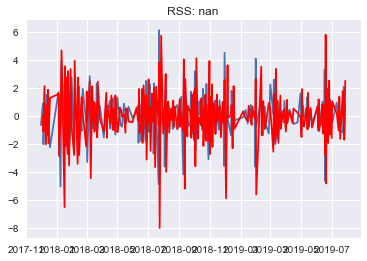

In [9]:
model_EIRE = ARIMA(ts_log_diff_EIRE, order=(1, 1, 0))  
results_AR_EIRE = model_EIRE.fit(disp=-1)  
plt.plot(ts_log_diff_EIRE)
plt.plot(results_AR_EIRE.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_EIRE.fittedvalues-ts_log_diff_EIRE)**2))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Text(0.5, 1.0, 'RSS: 273.5017')

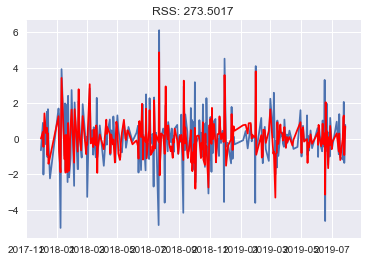

In [10]:
model_EIRE = ARIMA(ts_log_EIRE, order=(2, 1, 1))  
results_ARIMA_EIRE = model_EIRE.fit(disp=-1)  
plt.plot(ts_log_diff_EIRE)
plt.plot(results_ARIMA_EIRE.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_EIRE.fittedvalues-ts_log_diff_EIRE)**2))

Text(0.5, 1.0, 'RMSE: 990.7199')

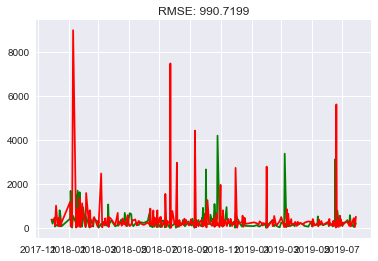

In [11]:
predictions_ARIMA_diff_EIRE = pd.Series(results_AR_EIRE.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_EIRE = predictions_ARIMA_diff_EIRE.cumsum()
predictions_ARIMA_log_EIRE = pd.Series(ts_log_EIRE.iloc[0], index=ts_log_EIRE.index)
predictions_ARIMA_log_EIRE = predictions_ARIMA_log_EIRE.add(predictions_ARIMA_diff_cumsum_EIRE,fill_value=0)
predictions_ARIMA_EIRE = np.exp(predictions_ARIMA_log_EIRE)
plt.plot(ts_EIRE, color='green')
plt.plot(predictions_ARIMA_EIRE, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_EIRE-ts_EIRE)**2)/len(ts_EIRE)))

In [12]:
predictions_ARIMA_EIRE.tail()

Date
2019-07-23    405.400136
2019-07-24    445.703758
2019-07-25    230.359410
2019-07-26     41.968738
2019-07-28    510.903247
dtype: float64

In [13]:
ts_EIRE.head()

Date
2017-11-28    375.99
2017-11-30    194.22
2017-12-04    470.65
2017-12-05     62.00
2017-12-07    133.31
Name: price, dtype: float64

##### Prophet 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-11-28,339.0,-133.0,771.0,339.0,339.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,0.0,0.0,0.0,323.0
1,2017-11-29,338.0,-139.0,800.0,338.0,338.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,0.0,0.0,0.0,326.0
2,2017-11-30,338.0,-145.0,811.0,338.0,338.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,0.0,0.0,0.0,331.0
3,2017-12-01,338.0,-112.0,865.0,338.0,338.0,63.0,63.0,63.0,63.0,63.0,63.0,0.0,0.0,0.0,401.0
4,2017-12-02,337.0,-122.0,850.0,337.0,337.0,15.0,15.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,352.0
5,2017-12-03,337.0,-176.0,790.0,337.0,337.0,-34.0,-34.0,-34.0,-34.0,-34.0,-34.0,0.0,0.0,0.0,304.0
6,2017-12-04,337.0,-157.0,792.0,337.0,337.0,-10.0,-10.0,-10.0,-10.0,-10.0,-10.0,0.0,0.0,0.0,327.0
7,2017-12-05,337.0,-167.0,808.0,337.0,337.0,-15.0,-15.0,-15.0,-15.0,-15.0,-15.0,0.0,0.0,0.0,321.0
8,2017-12-06,336.0,-149.0,789.0,336.0,336.0,-12.0,-12.0,-12.0,-12.0,-12.0,-12.0,0.0,0.0,0.0,324.0
9,2017-12-07,336.0,-125.0,790.0,336.0,336.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,0.0,0.0,0.0,329.0


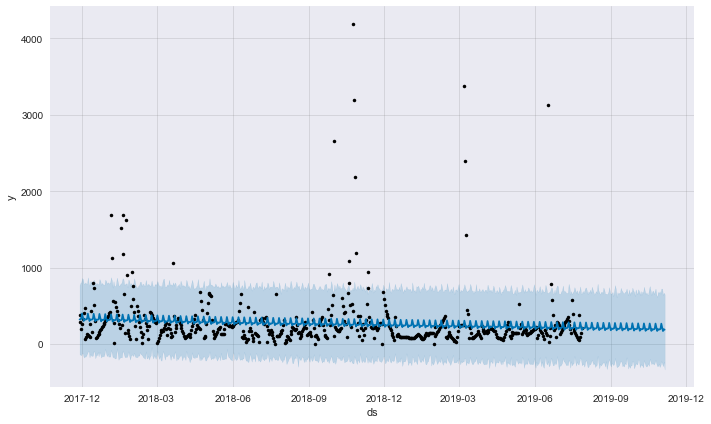

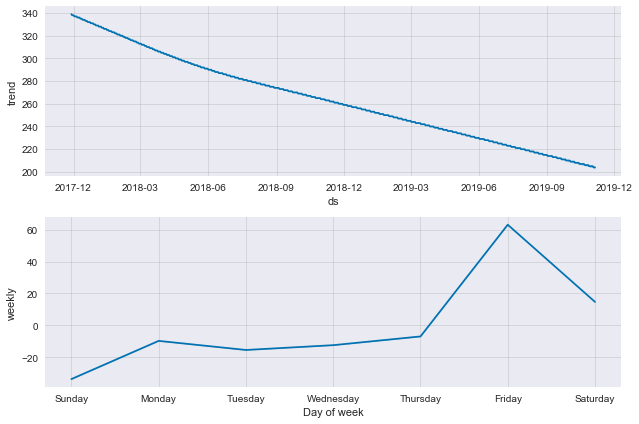

In [14]:
prophet_forecast(df_day_EIRE, 100)